This notebook will build my final submission for the coursera project.

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Data fields description:
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date - date in format dd/mm/yyyy
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from calendar import monthrange
from googletrans import Translator

from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

Load the training data and create some new features based on the date field.

In [2]:
data_df = pd.read_csv('./data/sales_train.csv')
print('Data rows:  {:,}'.format(len(data_df)))

data_df['date'] = pd.to_datetime(data_df['date'], format='%d.%m.%Y')

# Let's break up the date field into constituent pieces.
data_df['date (year)'] = data_df['date'].dt.year
data_df['date (month)'] = data_df['date'].dt.month
data_df['date (days in month)'] = data_df['date'].apply(lambda x: monthrange(x.year, x.month)[1])

data_df.head(2).transpose()

Data rows:  2,935,849


,0,1
date,2013-01-02 00:00:00,2013-01-03 00:00:00
date_block_num,0,0
shop_id,59,25
item_id,22154,2552
item_price,999,899
item_cnt_day,1,1
date (year),2013,2013
date (month),1,1
date (days in month),31,31


Let's inspect the counts and prices looking for outliers.

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64
Prices over 40k?  14


(array([2.935632e+06, 2.160000e+02, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([-1.000000e+00,  3.079710e+04,  6.159520e+04,  9.239330e+04,
         1.231914e+05,  1.539895e+05,  1.847876e+05,  2.155857e+05,
         2.463838e+05,  2.771819e+05,  3.079800e+05]),
 <a list of 10 Patch objects>)

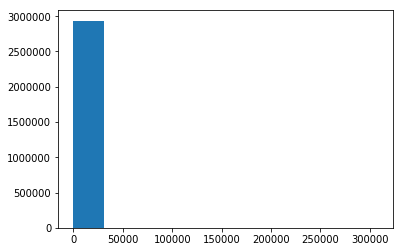

In [3]:
print(data_df['item_price'].describe())
print('Prices over 40k?  {:,}'.format(len(data_df[data_df['item_price'] >= 40000])))

plt.hist(data_df['item_price'])

Let's remove any prices less than 0 and greater than 40,000.

(array([2.883039e+06, 2.704600e+04, 7.923000e+03, 7.924000e+03,
        2.868000e+03, 2.104000e+03, 2.973000e+03, 1.731000e+03,
        1.920000e+02, 3.400000e+01]),
 array([7.0000000e-02, 3.7991630e+03, 7.5982560e+03, 1.1397349e+04,
        1.5196442e+04, 1.8995535e+04, 2.2794628e+04, 2.6593721e+04,
        3.0392814e+04, 3.4191907e+04, 3.7991000e+04]),
 <a list of 10 Patch objects>)

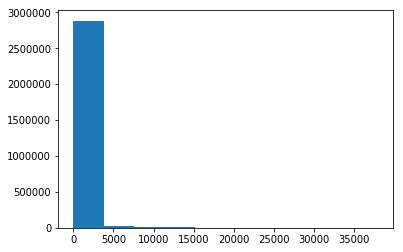

In [4]:
data_df = data_df[
    (data_df['item_price'] >= 0) &
    (data_df['item_price'] < 40000)
]

plt.hist(data_df['item_price'])

count    2.935834e+06
mean     1.242642e+00
std      2.618841e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64
Counts over 1000?  1


(array([2.935795e+06, 2.400000e+01, 1.100000e+01, 2.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([ -22. ,  197.1,  416.2,  635.3,  854.4, 1073.5, 1292.6, 1511.7,
        1730.8, 1949.9, 2169. ]),
 <a list of 10 Patch objects>)

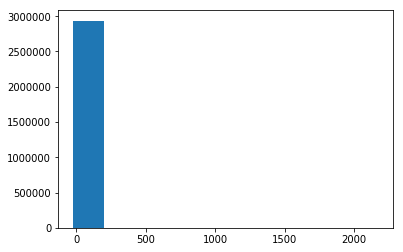

In [5]:
print(data_df['item_cnt_day'].describe())
print('Counts over 1000?  {:,}'.format(len(data_df[data_df['item_cnt_day'] > 1000])))

plt.hist(data_df['item_cnt_day'])

Let's remove the one count that is greater than 1000.

(array([2.935615e+06, 1.770000e+02, 1.600000e+01, 7.000000e+00,
        5.000000e+00, 9.000000e+00, 3.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([ -22. ,   80.2,  182.4,  284.6,  386.8,  489. ,  591.2,  693.4,
         795.6,  897.8, 1000. ]),
 <a list of 10 Patch objects>)

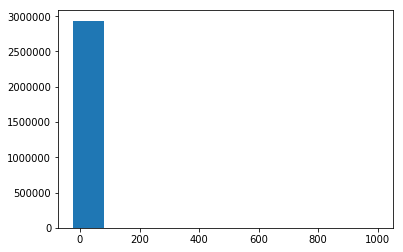

In [6]:
data_df = data_df[data_df['item_cnt_day'] < 1001]

plt.hist(data_df['item_cnt_day'])

In [7]:
item_categories_df = pd.read_csv('./data/item_categories.csv')
print('Item Categories:  {:,}'.format(len(item_categories_df)))

item_categories_df['item_category_id'] = item_categories_df['item_category_id'].astype(int)

translator = Translator()

item_categories_df['item_category_name (english)'] = item_categories_df['item_category_name'].apply(lambda x: translator.translate(x).text)

item_categories_df.to_csv('./data/ic_english.csv', index=False)

# Following english categories were taken from the output file written above.
def get_english_category(x):
    if 0 <= x <= 7:
        return 'Accessories'
    elif 10 <= x <= 17:
        return 'Game Consoles'
    elif 18 <= x <= 31:
        return 'Games'
    elif 32 <= x <= 36:
        return 'Gift Cards'
    elif 37 <= x <= 41:
        return 'Movies'
    elif 42 <= x <= 54:
        return 'Books'
    elif 55 <= x <= 60:
        return 'Music'
    elif 61 <= x <= 72:
        return 'Gifts'
    elif 73 <= x <= 79:
        return 'Software'
    else:
        return 'Misc'
    
item_categories_df['cat_name (normalized)'] = item_categories_df['item_category_id'].apply(lambda x: get_english_category(x))
item_categories_df['cat_name (normalized)'] = item_categories_df['cat_name (normalized)'].astype('category')

item_categories_df['cat_name (code)'] = item_categories_df['cat_name (normalized)'].cat.codes

item_categories_df

Item Categories:  84


,item_category_name,item_category_id,item_category_name (english),cat_name (normalized),cat_name (code)
0,PC - Гарнитуры/Наушники,0,PC - Headsets / Headphones,Accessories,0
1,Аксессуары - PS2,1,Accessories - PS2,Accessories,0
2,Аксессуары - PS3,2,Accessories - PS3,Accessories,0
3,Аксессуары - PS4,3,Accessories - PS4,Accessories,0
4,Аксессуары - PSP,4,Accessories - PSP,Accessories,0
5,Аксессуары - PSVita,5,Accessories - PSVita,Accessories,0
6,Аксессуары - XBOX 360,6,Accessories - XBOX 360,Accessories,0
7,Аксессуары - XBOX ONE,7,Accessories - XBOX ONE,Accessories,0
8,Билеты (Цифра),8,Tickets (digits),Misc,6
9,Доставка товара,9,Delivery of goods,Misc,6


In [8]:
items_df = pd.read_csv('./data/items.csv')
print('Items:  {:,}'.format(len(items_df)))

items_df['item_id'] = items_df['item_id'].astype(int)
items_df['item_category_id'] = items_df['item_category_id'].astype(int)

items_df.head(3)

Items:  22,170


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [9]:
shops_df = pd.read_csv('./data/shops.csv')
print('Shop rows:  {:,}'.format(len(shops_df)))

shops_df['shop_id'] = shops_df['shop_id'].astype(int)
shops_df['shop_name (english)'] = shops_df['shop_name'].apply(lambda x: translator.translate(x).text)

shops_df['shop_loc'] = shops_df['shop_name'].apply(lambda x: str(x).split(' ')[0]).astype('category')
shops_df['shop_loc (code)'] = shops_df['shop_loc'].cat.codes

shops_df.head(3)

Shop rows:  60


,shop_name,shop_id,shop_name (english),shop_loc,shop_loc (code)
0,"!Якутск Орджоникидзе, 56 фран",0,"! Yakutsk Ordzhonikidze, 56 Franc",!Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,"! Yakutsk TC ""Central"" Franc",!Якутск,0
2,"Адыгея ТЦ ""Мега""",2,"Adygea TC ""Mega""",Адыгея,1


Since we are trying to predict a future month, we need to convert the data into a monthly format.

In [10]:
monthly_df = data_df.groupby(['shop_id', 'item_id', 'date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()
monthly_df.columns = ['shop_id', 'item_id', 'date_block_num', 'item_cnt_month']

Load the test data and merge into the big dataset.

In [11]:
test_df = pd.read_csv('./data/test.csv')
print('Test rows:  {:,}'.format(len(test_df)))

# Fixed values.
test_df['date_block_num'] = 34
test_df['date (year)'] = 2015
test_df['date (month)'] = 11
test_df['date (days in month)'] = 30

# Update the prices with the latest month's prices.
last_month_df = data_df[data_df['date_block_num'] == 33][['shop_id', 'item_id', 'item_price']]

test_df = test_df.merge(last_month_df, on=['shop_id', 'item_id'], how='left')

test_df = test_df.drop_duplicates('ID', keep='first')

print('Test rows (after merge):  {:,}'.format(len(test_df)))

test_df[test_df['item_price'] > 0].head(2).T

Test rows:  214,200
Test rows (after merge):  214,200


,2,5
ID,2.0,5.0
shop_id,5.0,5.0
item_id,5233.0,5039.0
date_block_num,34.0,34.0
date (year),2015.0,2015.0
date (month),11.0,11.0
date (days in month),30.0,30.0
item_price,1199.0,1499.0


In [12]:
data_df = pd.concat([data_df, test_df], ignore_index=True, sort=False)

print('Rows:  {:,}'.format(len(data_df)))

Rows:  3,150,033


Merge the monthly results back into the training dataframe.

In [13]:
print('Training before merge:  {:,}'.format(len(data_df)))

data_df = data_df.merge(monthly_df, on=['shop_id', 'item_id', 'date_block_num'], how='left')
data_df = data_df.fillna(0)

data_df = data_df.merge(items_df[['item_id', 'item_category_id']], on='item_id', how='left')
data_df = data_df.merge(item_categories_df[['item_category_id', 'cat_name (code)']], on='item_category_id', how='left')
data_df = data_df.merge(shops_df[['shop_id', 'shop_loc (code)']], on='shop_id', how='left')

data_df['date_block_num'] = data_df['date_block_num'].astype('int')
data_df['shop_id'] = data_df['shop_id'].astype('int')
data_df['item_id'] = data_df['item_id'].astype('int')
data_df['item_category_id'] = data_df['item_category_id'].astype('int')
data_df['date (year)'] = data_df['date (year)'].astype('int')
data_df['date (month)'] = data_df['date (month)'].astype('int')
data_df['date (days in month)'] = data_df['date (days in month)'].astype('int')

print('Training after merge:  {:,}'.format(len(data_df)))

# Drop the daily columns that aren't needed.
data_df = data_df.drop(['date', 'item_cnt_day'], axis=1)

data_df.head(2).T

Training before merge:  3,150,033
Training after merge:  3,150,033


,0,1
date_block_num,0.0,0.0
shop_id,59.0,25.0
item_id,22154.0,2552.0
item_price,999.0,899.0
date (year),2013.0,2013.0
date (month),1.0,1.0
date (days in month),31.0,31.0
ID,0.0,0.0
item_cnt_month,1.0,0.0
item_category_id,37.0,58.0


Let's only train the ML algorithms on shops and items that are present in the prediction (test) set.

In [14]:
data_df = data_df[
    (data_df['shop_id'].isin(test_df['shop_id'].unique())) &
    (data_df['item_id'].isin(test_df['item_id'].unique()))
]
print('Training after removing shops/items not in the test set:  {:,}'.format(len(data_df)))

Training after removing shops/items not in the test set:  1,438,629


Since later on we will clip on item counts between 0 and 20, let's only use those values to train.

In [15]:
data_df = data_df[
    (data_df['item_cnt_month'] >= 0) &
    (data_df['item_cnt_month'] <= 20)
]
print('Training after clipping (0, 20) on the target variable:  {:,}'.format(len(data_df)))

Training after clipping (0, 20) on the target variable:  1,342,045


In [16]:
data_df['item_cnt_month'].describe()

count    1.342045e+06
mean     3.419804e+00
std      4.017064e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

Counts of a negative number represent "returns".  Thus, let's take these values out.

In [17]:
print('Rows before returns removed:  {:,}'.format(len(data_df)))

data_df = data_df[data_df['item_cnt_month'] >= 0]

print('Rows after returns removed:  {:,}'.format(len(data_df)))

Rows before returns removed:  1,342,045
Rows after returns removed:  1,342,045


In [18]:
data_df['item_cnt_month'].describe()

count    1.342045e+06
mean     3.419804e+00
std      4.017064e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

In [19]:
data_df['item_price'].describe()

count    1.342045e+06
mean     8.761089e+02
std      1.687727e+03
min      0.000000e+00
25%      1.990000e+02
50%      3.990000e+02
75%      9.995000e+02
max      3.799100e+04
Name: item_price, dtype: float64

Some item's are priced negatively.  Instead of zero, let's use the median here.

In [20]:
price_median = np.median(data_df['item_price'])
print('Price median:  {:}'.format(price_median))

data_df['item_price'] = data_df['item_price'].apply(lambda x: x if x >= 0 else price_median)

Price median:  399.0


In [21]:
data_df['item_price'].describe()

count    1.342045e+06
mean     8.761089e+02
std      1.687727e+03
min      0.000000e+00
25%      1.990000e+02
50%      3.990000e+02
75%      9.995000e+02
max      3.799100e+04
Name: item_price, dtype: float64

Let's incorporate the shop data structure with a couple of features.

In [22]:
grouped_df = data_df.groupby('shop_id').agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['shop_id', 'shop_cnt_month (mean)']

data_df = data_df.merge(grouped_df, on='shop_id', how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

grouped_df = data_df.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['shop_id', 'item_id', 'shop_item_cnt_month (mean)']

data_df = data_df.merge(grouped_df, on=['shop_id', 'item_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))
                                       
data_df.head(2).T

Rows after merge:  1,342,045
Rows after merge:  1,342,045


,0,1
date_block_num,0.00000,0.000000
shop_id,59.00000,25.000000
item_id,22154.00000,2574.000000
item_price,999.00000,399.000000
date (year),2013.00000,2013.000000
date (month),1.00000,1.000000
date (days in month),31.00000,31.000000
ID,0.00000,0.000000
item_cnt_month,1.00000,13.000000
item_category_id,37.00000,55.000000


<BarContainer object of 12 artists>

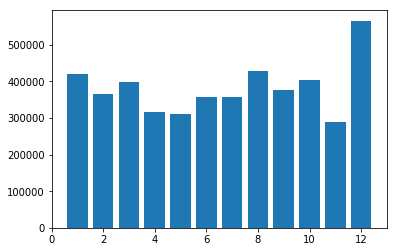

In [23]:
grouped_df = data_df.groupby('date (month)').agg({'item_cnt_month': 'sum'}).reset_index()
grouped_df.columns = ['month', 'item_cnt_month']

plt.bar(grouped_df['month'], grouped_df['item_cnt_month'])

Create a feature to account for the holiday buying season.

In [24]:
data_df['date (holiday season)'] = data_df['date (month)'].apply(lambda x: 1 if x == 12 else 0)

Create a revenue data feature.

In [25]:
data_df['revenue_month'] = data_df['item_price'] * data_df['item_cnt_month']

In [26]:
data_df['item_price (unit)'] = data_df['item_price'] // data_df['item_cnt_month']
data_df['item_price (unit)'] = data_df['item_price (unit)'].fillna(0.0)

Add some mean encoded features.

In [27]:
# Item count by date_block_num
grouped_df = data_df.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'item_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by month
grouped_df = data_df.groupby(['date (month)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (month)', 'item_cnt_mef (month)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (month)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))
print('')

# Item count by year
grouped_df = data_df.groupby(['date (year)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (year)', 'item_cnt_mef (year)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (year)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))
print('')

# Item count by item_category, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'item_category_id', 'item_cat_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'item_category_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by item_category, month
grouped_df = data_df.groupby(['date (month)', 'item_category_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (month)', 'item_category_id', 'item_cat_cnt_mef (month)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (month)', 'item_category_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by cat (code), month
grouped_df = data_df.groupby(['date (month)', 'cat_name (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (month)', 'cat_name (code)', 'cat_name_cnt_mef (month)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (month)', 'cat_name (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by cat (code), shop, month
grouped_df = data_df.groupby(['date (month)', 'shop_id', 'cat_name (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date (month)', 'cat_name (code)', 'shop_id', 'cat_name_shop_cnt_mef (month)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date (month)', 'shop_id', 'cat_name (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by cat (code), shop, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_id', 'cat_name (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'cat_name (code)', 'shop_id', 'cat_name_shop_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_id', 'cat_name (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by shop_loc, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_loc (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_loc (code)', 'shop_loc_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_loc (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by shop_loc, item, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_loc (code)', 'item_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_loc (code)', 'item_id', 'shop_loc_item_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_loc (code)', 'item_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by shop_loc, cat (code), date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_loc (code)', 'cat_name (code)']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_loc (code)', 'cat_name (code)', 'shop_loc_cat_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_loc (code)', 'cat_name (code)'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

# Item count by shop_loc, cat item_category, date_block_num
grouped_df = data_df.groupby(['date_block_num', 'shop_loc (code)', 'item_category_id']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'shop_loc (code)', 'item_category_id', 'shop_loc_item_cat_cnt_mef (date_block_num)']

print(grouped_df.head(3))
print('')

data_df = pd.merge(data_df, grouped_df, on=['date_block_num', 'shop_loc (code)', 'item_category_id'], how='left')
print('Rows after merge:  {:,}'.format(len(data_df)))

   date_block_num  item_cnt_mef (date_block_num)
0  0               4.773936                     
1  1               4.568820                     
2  2               5.027601                     

Rows after merge:  1,342,045
   date (month)  item_cnt_mef (month)
0  1             4.392874            
1  2             4.126961            
2  3             4.128313            

Rows after merge:  1,342,045

   date (year)  item_cnt_mef (year)
0  2013         4.683337           
1  2014         4.346230           
2  2015         2.305500           

Rows after merge:  1,342,045

   date_block_num  item_category_id  item_cat_cnt_mef (date_block_num)
0  0               2                 6.848000                         
1  0               5                 2.220930                         
2  0               6                 5.979328                         

Rows after merge:  1,342,045
   date (month)  item_category_id  item_cat_cnt_mef (month)
0  1             2                 4.57678

Now, let's add some lagged features.

In [28]:
month_lags = [1, 2, 3, 6, 12]
col_lags = [
    'item_cnt_month', 
    'item_price', 
    'revenue_month', 
    'item_cnt_mef (date_block_num)', 
    'item_cat_cnt_mef (date_block_num)',
    'item_cat_cnt_mef (month)',
    'shop_cnt_month (mean)', 
    'shop_item_cnt_month (mean)',
    'cat_name_cnt_mef (month)',
    'cat_name_shop_cnt_mef (month)',
    'cat_name_shop_cnt_mef (date_block_num)',
    'shop_loc_cnt_mef (date_block_num)',
    'shop_loc_item_cnt_mef (date_block_num)',
    'shop_loc_item_cat_cnt_mef (date_block_num)',
    'shop_loc_cat_cnt_mef (date_block_num)'
]

for col in col_lags:
    for month in month_lags:
        new_col = '{:} (-{:})'.format(col, month)
        data_df[new_col] = data_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])[col].shift(month)
        data_df[new_col] = data_df[new_col].fillna(0.0)
                    
data_df.head(2).T

,0,1
date_block_num,0.000000,0.000000
shop_id,59.000000,25.000000
item_id,22154.000000,2574.000000
item_price,999.000000,399.000000
date (year),2013.000000,2013.000000
date (month),1.000000,1.000000
date (days in month),31.000000,31.000000
ID,0.000000,0.000000
item_cnt_month,1.000000,13.000000
item_category_id,37.000000,55.000000


Add a feature to mark the month of the first sale.

In [29]:
data_df['shop (first sale)'] = data_df['date_block_num'] - data_df.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')

In [30]:
data_df.describe()

,date_block_num,shop_id,item_id,item_price,date (year),date (month),date (days in month),ID,item_cnt_month,item_category_id,...,shop_loc_item_cat_cnt_mef (date_block_num) (-2),shop_loc_item_cat_cnt_mef (date_block_num) (-3),shop_loc_item_cat_cnt_mef (date_block_num) (-6),shop_loc_item_cat_cnt_mef (date_block_num) (-12),shop_loc_cat_cnt_mef (date_block_num) (-1),shop_loc_cat_cnt_mef (date_block_num) (-2),shop_loc_cat_cnt_mef (date_block_num) (-3),shop_loc_cat_cnt_mef (date_block_num) (-6),shop_loc_cat_cnt_mef (date_block_num) (-12),shop (first sale)
count,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,...,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06,1.342045e+06
mean,2.182677e+01,3.210392e+01,9.701460e+03,8.761089e+02,2.014295e+03,7.283477e+00,3.038952e+01,1.709385e+04,3.419804e+00,4.118193e+01,...,3.207870e+00,3.024846e+00,2.582386e+00,1.979771e+00,3.419804e+00,3.186456e+00,2.988137e+00,2.519478e+00,1.902187e+00,8.037991e+00
std,9.902276e+00,1.669005e+01,6.191259e+03,1.687727e+03,7.669936e-01,3.552638e+00,7.958571e-01,4.635513e+04,4.017064e+00,1.806919e+01,...,2.712888e+00,2.799643e+00,2.926089e+00,2.926741e+00,2.286845e+00,2.444579e+00,2.546097e+00,2.690095e+00,2.698908e+00,8.720723e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,0.000000e+00,2.013000e+03,1.000000e+00,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,1.900000e+01,4.244000e+03,1.990000e+02,2.014000e+03,4.000000e+00,3.000000e+01,0.000000e+00,1.000000e+00,2.800000e+01,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.836478e+00,1.307692e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.300000e+01,3.100000e+01,8.093000e+03,3.990000e+02,2.014000e+03,8.000000e+00,3.100000e+01,0.000000e+00,2.000000e+00,4.000000e+01,...,2.919206e+00,2.700000e+00,1.887931e+00,0.000000e+00,3.402597e+00,3.242553e+00,3.030303e+00,2.109091e+00,0.000000e+00,5.000000e+00
75%,3.100000e+01,4.700000e+01,1.521300e+04,9.995000e+02,2.015000e+03,1.100000e+01,3.100000e+01,0.000000e+00,4.000000e+00,5.500000e+01,...,4.984263e+00,4.920455e+00,4.744845e+00,4.000000e+00,4.886598e+00,4.845161e+00,4.808743e+00,4.633645e+00,4.173638e+00,1.300000e+01
max,3.400000e+01,5.900000e+01,2.216700e+04,3.799100e+04,2.015000e+03,1.200000e+01,3.100000e+01,2.141990e+05,2.000000e+01,8.300000e+01,...,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,3.400000e+01


Ensure that all NA fields have 0.0 and downcast the data-types to save on some memory.

In [31]:
data_df = data_df.fillna(0.0)

float_cols = [col for col in data_df if data_df[col].dtype == 'float64']
int_cols = [col for col in data_df if data_df[col].dtype in ['int64', 'int32']]

data_df[float_cols] = data_df[float_cols].astype(np.float32)
data_df[int_cols] = data_df[int_cols].astype(np.int16)

We will use date_block_num == 33 for the test set, date_block_num == 34 for the prediction set, and all other rows as training.  
Since we are using 12 month's of lagged data, discard any training rows between 0 and 11.

In [32]:
train_df = data_df[
    (data_df['date_block_num'] > 11) & 
    (data_df['date_block_num'] < 33)
]
test_df = data_df[data_df['date_block_num'] == 33]
pred_df = data_df[data_df['date_block_num'] == 34]

print('  Training rows:  {:,}'.format(len(train_df)))
print('   Testing rows:  {:,}'.format(len(test_df)))
print('Prediction rows:  {:,}'.format(len(pred_df)))

  Training rows:  825,912
   Testing rows:  46,816
Prediction rows:  214,200


In [33]:
cols_to_drop = ['ID', 'item_cnt_month', 'revenue_month']

X_train = train_df.drop(cols_to_drop, axis=1)
y_train = train_df['item_cnt_month']

X_test = test_df.drop(cols_to_drop, axis=1)
y_test = test_df['item_cnt_month']

X_pred = pred_df.drop(cols_to_drop, axis=1)

X_pred.head(5)

,date_block_num,shop_id,item_id,item_price,date (year),date (month),date (days in month),item_category_id,cat_name (code),shop_loc (code),...,shop_loc_item_cat_cnt_mef (date_block_num) (-2),shop_loc_item_cat_cnt_mef (date_block_num) (-3),shop_loc_item_cat_cnt_mef (date_block_num) (-6),shop_loc_item_cat_cnt_mef (date_block_num) (-12),shop_loc_cat_cnt_mef (date_block_num) (-1),shop_loc_cat_cnt_mef (date_block_num) (-2),shop_loc_cat_cnt_mef (date_block_num) (-3),shop_loc_cat_cnt_mef (date_block_num) (-6),shop_loc_cat_cnt_mef (date_block_num) (-12),shop (first sale)
1127845,34,5,5037,0.0,2015,11,30,19,3,4,...,5.007936,5.007936,2.984375,4.26,3.273458,3.789030,3.789030,3.289308,4.685629,14
1127846,34,5,5320,0.0,2015,11,30,55,8,4,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0
1127847,34,5,5233,1199.0,2015,11,30,19,3,4,...,3.636364,3.636364,2.984375,0.00,3.814714,3.273458,3.273458,3.289308,0.000000,6
1127848,34,5,5232,0.0,2015,11,30,23,3,4,...,0.000000,0.000000,0.000000,0.00,3.789030,0.000000,0.000000,0.000000,0.000000,3
1127849,34,5,5268,0.0,2015,11,30,20,3,4,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0


Now train the regressor.

In [ ]:
xgb = XGBRegressor(seed=1, 
                   n_estimators=500,
                   max_depth=8,
                   min_child_weight=300,
                   eta=0.3,
                   subsample=0.8,
                   colsample_bytree=0.8
)

xgb.fit(X_train, 
        y_train, 
        eval_metric='rmse',  
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=True, 
        early_stopping_rounds=10)

c:\users\craig\anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\craig\anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.71523	validation_1-rmse:4.06466
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:4.26297	validation_1-rmse:3.67929
[2]	validation_0-rmse:3.8513	validation_1-rmse:3.32483
[3]	validation_0-rmse:3.48181	validation_1-rmse:3.00651
[4]	validation_0-rmse:3.15005	validation_1-rmse:2.72044
[5]	validation_0-rmse:2.85294	validation_1-rmse:2.46457
[6]	validation_0-rmse:2.5857	validation_1-rmse:2.23619
[7]	validation_0-rmse:2.35161	validation_1-rmse:2.03484
[8]	validation_0-rmse:2.13347	validation_1-rmse:1.84701
[9]	validation_0-rmse:1.9382	validation_1-rmse:1.67832
[10]	validation_0-rmse:1.7646	validation_1-rmse:1.52803
[11]	validation_0-rmse:1.60921	validation_1-rmse:1.39436
[12]	va

[134]	validation_0-rmse:0.245259	validation_1-rmse:0.24352
[135]	validation_0-rmse:0.245053	validation_1-rmse:0.243285
[136]	validation_0-rmse:0.244525	validation_1-rmse:0.242907
[137]	validation_0-rmse:0.24376	validation_1-rmse:0.242528
[138]	validation_0-rmse:0.243137	validation_1-rmse:0.242075
[139]	validation_0-rmse:0.242589	validation_1-rmse:0.241655
[140]	validation_0-rmse:0.241756	validation_1-rmse:0.241101
[141]	validation_0-rmse:0.241526	validation_1-rmse:0.240902
[142]	validation_0-rmse:0.241326	validation_1-rmse:0.240795
[143]	validation_0-rmse:0.240711	validation_1-rmse:0.240497
[144]	validation_0-rmse:0.240017	validation_1-rmse:0.240201
[145]	validation_0-rmse:0.239435	validation_1-rmse:0.239663
[146]	validation_0-rmse:0.23877	validation_1-rmse:0.23947
[147]	validation_0-rmse:0.23791	validation_1-rmse:0.238777
[148]	validation_0-rmse:0.237273	validation_1-rmse:0.238439
[149]	validation_0-rmse:0.236724	validation_1-rmse:0.238051
[150]	validation_0-rmse:0.236157	validation_1

In [ ]:
plt.rcParams['figure.figsize'] = (20, 16)

plot_importance(xgb)

In [ ]:
pred_df['item_cnt_month'] = xgb.predict(X_pred).clip(0, 20)

pred_df['ID'] = pred_df['ID'].astype(int)

pred_df[['ID', 'item_cnt_month']].to_csv('submissions/final_submission.csv', index=False)

In [ ]:
bagged_df = pd.read_csv('submissions/submission-Oct-2015.csv')
bagged_df.head(5)

In [ ]:
pred_df[['ID', 'item_cnt_month']].head(5)

In [ ]:
bagged_df = bagged_df.merge(pred_df[['ID', 'item_cnt_month']], on='ID')
bagged_df.head(5)

In [ ]:
bagged_df.columns = ['ID', 'item_cnt_month (oct)', 'item_cnt_month (ML)']

In [ ]:
bagged_df.head(5)

In [ ]:
def get_bagged_value(row):
    return 0 if row['item_cnt_month (oct)'] == 0.0 else row['item_cnt_month (ML)']

In [ ]:
bagged_df['item_cnt_month'] = bagged_df.apply(lambda row: get_bagged_value(row), axis=1)

bagged_df.head(5)

In [ ]:
bagged_df[['ID', 'item_cnt_month']].to_csv('./submissions/bagged-or.csv', index=False)

In [ ]:
bagged_df['item_cnt_month (add)'] = bagged_df['item_cnt_month (ML)'] + bagged_df['item_cnt_month (oct)']
bagged_df[['ID', 'item_cnt_month (add)']].to_csv('./submissions/bagged-add.csv', index=False)

In [ ]:
bagged_df['item_cnt_month (avg)'] = (bagged_df['item_cnt_month (ML)'] + bagged_df['item_cnt_month (oct)']) / 2
bagged_df[['ID', 'item_cnt_month (avg)']].to_csv('./submissions/bagged-avg.csv', index=False)